In [16]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy import signal
from scipy.fft import fftshift
from mpl_toolkits import mplot3d
import librosa
import os

In [121]:
# Creating base data
# used to see the wav files and the emotion it's associated with. Don't modify this dataframe. 
# It'll be used to make the main dataframe
filesDF = pd.DataFrame(columns=["emotion", "wav"])
crema = "./Crema/"

sad=[]
angry=[]
disgust=[]
fear=[]
happy=[]
neutral=[]

for wav in os.listdir(crema):
    info = wav.partition(".wav")[0].split("_")
    if info[2] == 'SAD':
        filesDF.loc[len(filesDF.index)] = ['sad', librosa.load(crema + wav)[0]]
    elif info[2] == 'ANG':
        filesDF.loc[len(filesDF.index)] = ['angry', librosa.load(crema + wav)[0]]
    elif info[2] == 'DIS':
        filesDF.loc[len(filesDF.index)] = ['disgust', librosa.load(crema + wav)[0]]
    elif info[2] == 'FEA':
        filesDF.loc[len(filesDF.index)] = ['fear', librosa.load(crema + wav)[0]]
    elif info[2] == 'HAP':
        filesDF.loc[len(filesDF.index)] = ['happy', librosa.load(crema + wav)[0]]
    elif info[2] == 'NEU':
        filesDF.loc[len(filesDF.index)] = ['neutral', librosa.load(crema + wav)[0]]

In [123]:
print(len(filesDF["wav"][1]))

51502


In [164]:
# make all audio files the same length

# longest wav file is ~100000, shortest is ~27000
# using the middle 20000 samples of every file.
sampe_rate=44100

for i in range(0,len(filesDF)):
    half_len = len(filesDF["wav"].loc[i])//2
    filesDF["wav"].loc[i] = filesDF["wav"].loc[i][half_len-10000:half_len+10000]

In [165]:
print(filesDF.head())

   emotion                                                wav
0    angry  [0.016720826, 0.0060386336, -0.0021542148, 0.0...
1  disgust  [-0.0006989376, 0.012909886, 0.010570439, 0.00...
2     fear  [-0.30263463, -0.24691129, -0.17649403, -0.123...
3    happy  [0.05772104, 0.05896825, 0.0556751, 0.05507051...
4  neutral  [-0.005238219, -0.0039871586, -0.0039100936, -...


In [166]:
# Create dataframe used for manipulation
df = filesDF.copy()
df = df.drop(columns=["wav"])

In [191]:
# declare features

# short-time fourier transform. basically the spectrogram of the signal. Used for visualization
# df["stft"]=0
# mean of the voice amplitude
df["wav_mean"]=0.0
# 
df["melspectrogram"]=0.0
# 
df["mfcc"]=0.0
# 
df["Chorma-stft"]=0.0
# 
df["Spectral_contrast"]=0.0
# 
df["Tonnetz"]=0.0

def features(wav):
    # stft
    # stft = librosa.stft(wav[1])
    # mean
    mean = abs(wav[1]).mean()
    # mel
    mel = np.mean(librosa.feature.melspectrogram(wav[1], sr=sample_rate).T,axis=0).mean()
    # mfcc
    mfcc = np.mean(librosa.feature.mfcc(y=wav[1], sr=sample_rate, n_mfcc=40).T,axis=0).mean()
    # return features
    return mean, mel, mfcc


# get features
for i in range(0,len(df)):
    mean, mel, mfcc = features(filesDF.iloc[i])
    # print(mean)
    df["wav_mean"].iloc[i] = mean
    df["melspectrogram"].iloc[i] = mel
    df["mfcc"].iloc[i] = mfcc

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [192]:
print(df.head())

   emotion  wav_mean  Melspectrogram  MFCC  Chorma-stft  Spectral_contrast  \
0    angry  0.045193        1.581002   0.0          0.0                0.0   
1  disgust  0.017393        0.189471   0.0          0.0                0.0   
2     fear  0.068280        4.014250   0.0          0.0                0.0   
3    happy  0.039849        1.368866   0.0          0.0                0.0   
4  neutral  0.019950        0.412746   0.0          0.0                0.0   

   Tonnetz  melspectrogram      mfcc  melspectrogram_mean  
0      0.0        1.581002 -4.676603             1.581002  
1      0.0        0.189471 -4.855009             0.000000  
2      0.0        4.014250 -5.055051             0.000000  
3      0.0        1.368866 -5.306521             0.000000  
4      0.0        0.412746 -5.019230             0.000000  


In [5]:
# Create dataframe used for manipulation
df = filesDF.copy()
df = df.drop(columns=["wav"])
df["mean"]=0
df["rmse"]=0

# calc rmse
def rmse(sig):
    total=0
    for i in range(0,samples):
        total += sig[i]**2
    rms = np.sqrt(abs(total/samples))
    return rms

# Add more features here based off the wave itself

for i in range(0, len(df)):
    # save the mean. Probably wont really use.
    df["mean"].loc[i] = abs(filesDF["wav"].loc[i].mean())
    # save rms of the energy of the signal
    df["rmse"].loc[i] = rmse(filesDF["wav"].loc[i])
    

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\devli\AppData\Local\Temp/ipykernel_17216/3737530147.py:11: RuntimeWarning: overflow encountered in int_scalars
  total += sig[i]**2


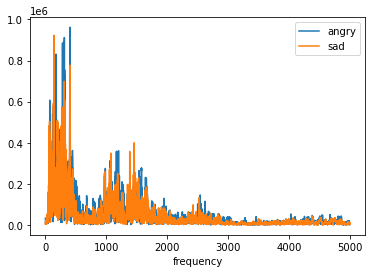

In [14]:
# visualize fft
# rate1, sig1 = wavfile.read(crema + "1001_DFA_ANG_XX.wav")
# rate2, sig2 = wavfile.read(crema + "1001_DFA_SAD_XX.wav")
sig1 = filesDF["wav"].loc[1]
sig2 = filesDF["wav"].loc[5]
sig_f1 = abs(np.fft.fft(sig1))
sig_f2 = abs(np.fft.fft(sig2))
len_f1 = len(sig_f1)
len_f2 = len(sig_f2)
half_len_f1 = int(np.ceil((len_f1 + 1) / 2))
half_len_f2 = int(np.ceil((len_f2 + 1) / 2))
sig_f1 = sig_f1[:half_len_f1]
sig_f2 = sig_f2[:half_len_f2]

plt.plot(sig_f1)
plt.plot(sig_f2)
plt.xlabel("frequency")
plt.legend(["angry", "sad"])

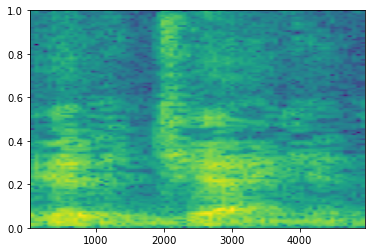

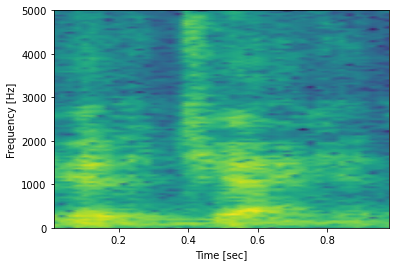

150.34677
44
129


In [11]:
# frequency domain data

df["average frequency"]=0
df["highest peak over 800Hz"]=0

sample_rate = 10000

for i in range(0, len(df)):
    # temp_fft = abs(np.fft.rfft(mdf["wav"].loc[i]))
    temp_freq, temp_time, spec = signal.spectrogram(filesDF["wav"].loc[i], sample_rate)
    df["average frequency"].loc[i] = spec.flatten().mean()
    
    m = max(temp_fft)
    df["highest peak over 800Hz"].loc[i] = np.where(t==k)
    print(np.where(t==m))

# a, b, c, d = plt.specgram(mdf["wav"].loc[5])
# plt.show()

# temp_freq, temp_time, spec = signal.spectrogram(mdf["wav"].loc[5], sample_rate)
# plt.pcolormesh(temp_time, temp_freq, 10*np.log(spec), shading='gouraud')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show()
# print(spec.flatten().mean())
# print(len(temp_time))
# print(len(temp_freq))
# plt.specgram(s)

In [ ]:
print(df)

      emotion    mean        rmse  average frequency  highest peak over 800Hz
0       angry  1.7453  127.350955                  0                        0
1     disgust  3.3016  161.223955                  0                        0
2        fear  1.5374   53.893450                  0                        0
3       happy  0.4316   63.253941                  0                        0
4     neutral  0.8085  332.760436                  0                        0
...       ...     ...         ...                ...                      ...
7437  disgust  1.1738  382.380176                  0                        0
7438     fear  2.5016  332.629848                  0                        0
7439    happy  1.1280  293.561066                  0                        0
7440  neutral  1.8103  358.981813                  0                        0
7441      sad  1.0034  300.983002                  0                        0

[7442 rows x 5 columns]


   emotion  wav_mean  Melspectrogram  MFCC  Chorma-stft  Spectral_contrast  \
0    angry  0.045193        1.581002   0.0          0.0                0.0   
1  disgust  0.017393        0.189471   0.0          0.0                0.0   
2     fear  0.068280        4.014250   0.0          0.0                0.0   
3    happy  0.039849        1.368866   0.0          0.0                0.0   
4  neutral  0.019950        0.412746   0.0          0.0                0.0   

   Tonnetz  melspectrogram      mfcc  melspectrogram_mean  
0      0.0        1.581002 -4.676603             1.581002  
1      0.0        0.189471 -4.855009             0.000000  
2      0.0        4.014250 -5.055051             0.000000  
3      0.0        1.368866 -5.306521             0.000000  
4      0.0        0.412746 -5.019230             0.000000  
                     wav_mean  Melspectrogram  MFCC  Chorma-stft  \
wav_mean             1.000000        0.935890   NaN          NaN   
Melspectrogram       0.935890      

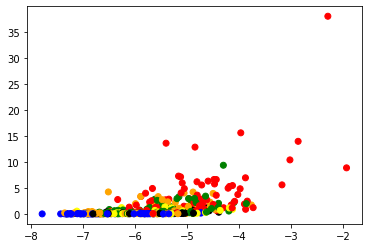

In [198]:
print(df.head())
print(df.corr())
colors = {"sad":"blue", "angry":"red", "disgust":"yellow", "fear":"orange", "happy":"green", "neutral":"black"}

plt.scatter(df["mfcc"][:500], df["melspectrogram"][:500], c=df["emotion"][:500].map(colors))

In [ ]:
# goal and features
goal = df["emotion"]
features = df[["wav_mean", "melspectrogram", "mfcc"]]

# split data
X_train, X_test, Y_train, Y_test = train_test_split(features, goal)

# use decision tree
model=tree.DecisionTreeClassifier(max_depth=5)

# train the model
model.fit(X_train,Y_train)

# training and testing accuracy
dtree_pred_train = model.predict(X_train)
dtree_pred_test = model.predict(X_test) 
print("Train Accuracy: ", accuracy_score(Y_train, dtree_pred_train))
print("Test Accuracy: ", accuracy_score(Y_test, dtree_pred_test))

# keras simplest
# pytorch
# tensor flow
# specified NN for time series

Train Accuracy:  0.20408528937466403
Test Accuracy:  0.18430951101558302
